### Imports & setup

In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


### Load dataset

In [49]:
# Path to dataset
DATA_PATH = "../data/ai4i_2020_predictive_maintenance.csv"

# Load CSV
df = pd.read_csv(DATA_PATH)

# Basic check
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Dataset overview

In [50]:
print("Dataset shape:", df.shape)
print("\nColumn info:")
df.info()

Dataset shape: (10000, 14)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-n

### Summary statistics

In [51]:
df.describe(include="all")

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
unique,NaN,10000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M24859,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,NaN,NaN,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,NaN,NaN,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,NaN,NaN,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,NaN,NaN,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,NaN,NaN,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,NaN,NaN,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### Missing values check

In [52]:
missing= df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

### Check uniqueness and duplicates

In [53]:
df.nunique().sort_values()
df.duplicated().sum()

0

### Target variable distribution

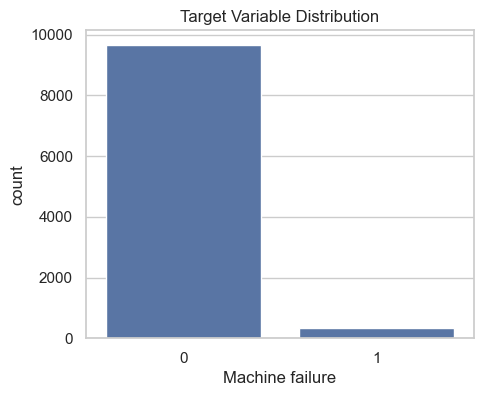

In [54]:
# Assuming 'Machine failure' is the target
target_col = "Machine failure"

df[target_col].value_counts(normalize=True)

plt.figure(figsize=(5, 4))
sns.countplot(x=target_col, data=df)
plt.title("Target Variable Distribution")
plt.show()

The target variable is highly imbalanced, with failures representing a small fraction of observations, which motivates the use of stratified sampling and appropriate evaluation metrics in downstream models.

### Identifying the time-series variable

In [55]:
df['Tool wear [min]'].describe()

count    10000.000000
mean       107.951000
std         63.654147
min          0.000000
25%         53.000000
50%        108.000000
75%        162.000000
max        253.000000
Name: Tool wear [min], dtype: float64

In [56]:
df = df.sort_values('Tool wear [min]').reset_index(drop=True)

### Failure vs key features

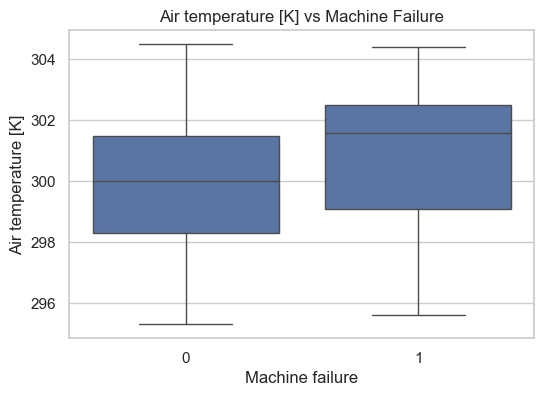

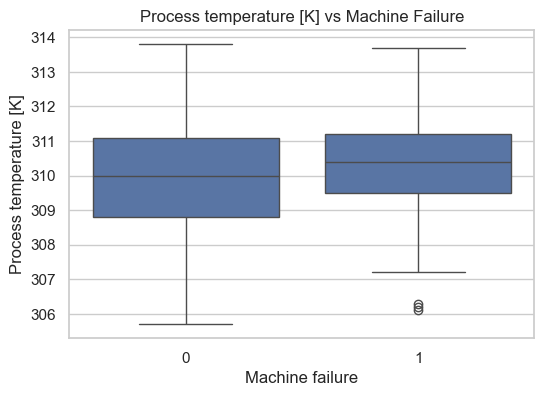

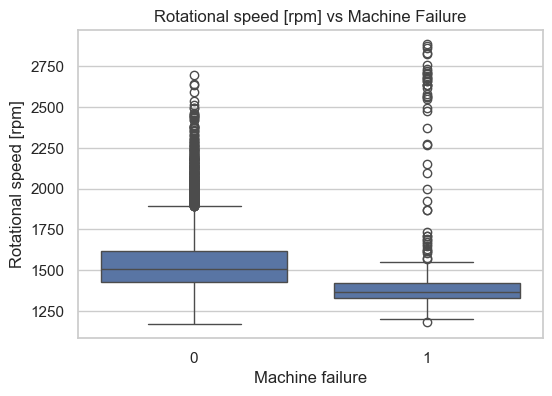

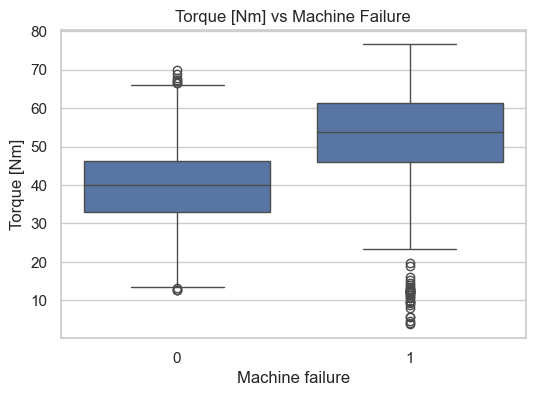

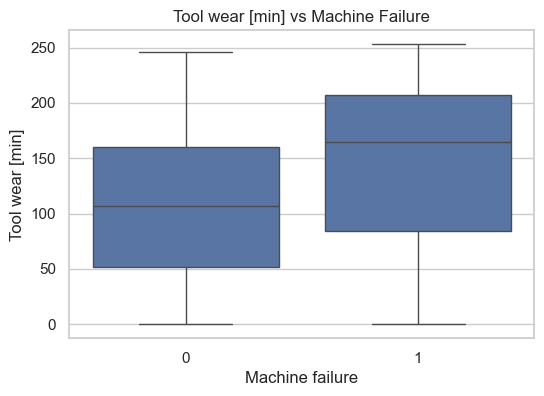

In [57]:
key_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

for feature in key_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_col, y=feature, data=df)
    plt.title(f"{feature} vs Machine Failure")
    plt.show()

### Correlation analysis

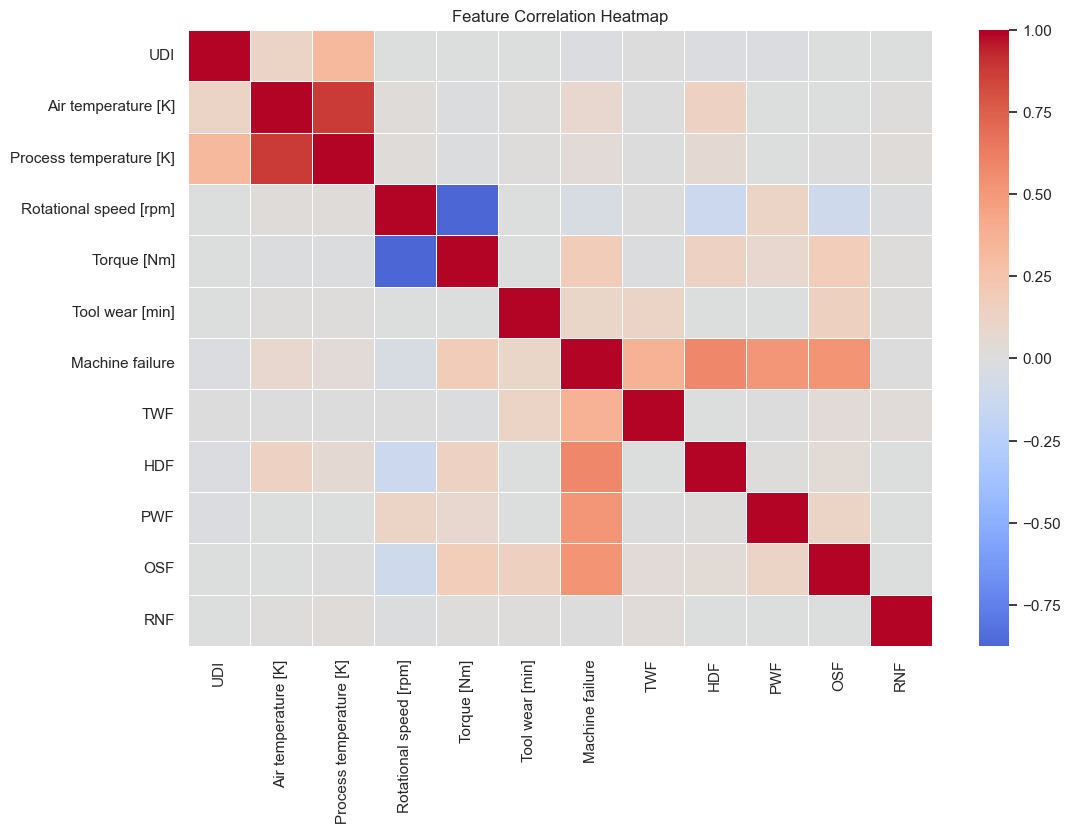

In [58]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12, 8))
corr = df[numerical_cols].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap")
plt.show()

### Time-series behavior using Tool wear

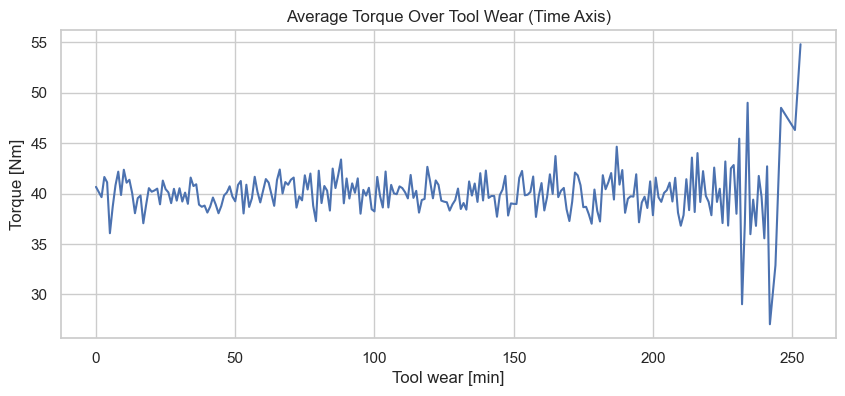

In [59]:
df_tw = df.groupby('Tool wear [min]', as_index=False).mean(numeric_only=True)

plt.figure(figsize=(10,4))
plt.plot(df_tw['Tool wear [min]'], df_tw['Torque [Nm]'])
plt.title("Average Torque Over Tool Wear (Time Axis)")
plt.xlabel("Tool wear [min]")
plt.ylabel("Torque [Nm]")
plt.show()

### Moving average smoothing to reduce noise

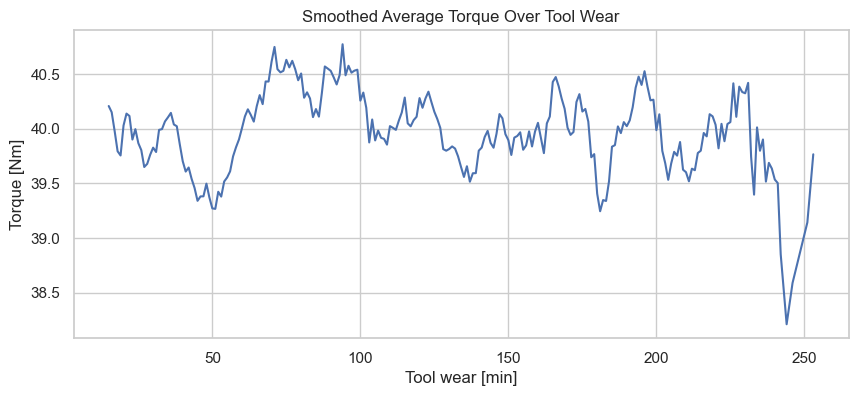

In [60]:
df_tw['Torque_ma'] = df_tw['Torque [Nm]'].rolling(window=15).mean()

plt.figure(figsize=(10,4))
plt.plot(df_tw['Tool wear [min]'], df_tw['Torque_ma'])
plt.title("Smoothed Average Torque Over Tool Wear")
plt.xlabel("Tool wear [min]")
plt.ylabel("Torque [Nm]")
plt.show()


### Basic preprocessing

In [61]:
# Prepare dataset for ML prep steps (remove IDs and leakage variables)
drop_cols = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df_prepared = df.drop(columns=drop_cols)

print("Dropped columns:", drop_cols)
print("Prepared dataset shape:", df_prepared.shape)


Dropped columns: ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Prepared dataset shape: (10000, 7)


Identifier fields and failure-mode indicators were removed prior to modeling to prevent data leakage and ensure that predictions are based only on sensor measurements and operational variables.

In [62]:
#Encoding 
df_prepared = pd.get_dummies(df_prepared, columns=['Type'], drop_first=True)


## Time-series prediction preparation

In [63]:
# Aggregate by tool wear to define a true time axis
df_tw = (
    df_prepared
    .groupby('Tool wear [min]', as_index=False)
    .mean(numeric_only=True)
    .sort_values('Tool wear [min]')
    .reset_index(drop=True)
)

# Define future target (one step ahead in time)
df_tw['Torque_future'] = df_tw['Torque [Nm]'].shift(-1)
df_tw = df_tw.dropna()

# Feature selection (no leakage)
ts_features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Tool wear [min]'
]

X_ts = df_tw[ts_features]
y_ts = df_tw['Torque_future']

# Train/test split by order (time-aware)
split_idx = int(len(df_tw) * 0.8)
X_ts_train = X_ts.iloc[:split_idx]
X_ts_test  = X_ts.iloc[split_idx:]
y_ts_train = y_ts.iloc[:split_idx]
y_ts_test  = y_ts.iloc[split_idx:]


In [64]:
# features scaling
ts_scaler = StandardScaler()
X_ts_train = ts_scaler.fit_transform(X_ts_train)
X_ts_test  = ts_scaler.transform(X_ts_test)


##  Deep Learning model preparation

In [65]:
X_dl = df_prepared.drop(columns=['Machine failure'])
y_dl = df_prepared['Machine failure']

#Train/test split
X_dl_train, X_dl_test, y_dl_train, y_dl_test = train_test_split(X_dl, y_dl, test_size=0.2, stratify=y_dl, random_state=42)

In [66]:
# scaling numerical features
dl_scaler = StandardScaler()
X_dl_train = dl_scaler.fit_transform(X_dl_train)
X_dl_test  = dl_scaler.transform(X_dl_test)

# Convert to float for TensorFlow
X_dl_train = X_dl_train.astype(np.float32)
X_dl_test  = X_dl_test.astype(np.float32)

y_dl_train = np.array(y_dl_train)
y_dl_test  = np.array(y_dl_test)

Tool wear was treated as the time variable for the time-series prediction task, with observations ordered chronologically and split without shuffling. For the deep learning model, sensor measurements and machine type were used to predict machine failure, with categorical encoding and feature scaling applied prior to training.